In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import *
from bootstrap_func import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter


import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = 'Arial'

cmap = plt.get_cmap('coolwarm', 9)
colors = cmap(np.linspace(0.1, 0.9, 9))

np.random.seed(42)
n_bootstrap = 2000

# Data loading and preprocessing
hairtail = pd.read_csv("./Data/cutlassfish.csv")
hairtail.dropna(inplace=True)
hairtail['mat'] = hairtail['maturity'].apply(maturity_01)

# Sample size
N_K = len(hairtail[hairtail.site=='K'])
N_T = len(hairtail[hairtail.site=='T'])
print("K: sample size =  ", N_K)
print("T: Sample size =  ", N_T)

hairtail.to_csv("./Data/cutlassfish_rmNAN.csv", index=False)

K: sample size =   247
T: Sample size =   148


## Growth model

The following code implemented 2000 bootstrap resamples to: 
(i) estimate fitted growth curves,
(ii) compute 95% confidence intervals, and
(iii) evaluate mean prediction errors for the EGM, QEGM and deep QGM models.

For the QGAGM model, all three analyses—growth curve estimation, confidence interval computation, and error evaluation—were performed using 2000 bootstrap resamples implemented in the R script `./qgam.R`.

- a-b: Exponential growth model (EGM) fits
- c-d: Quantile exponential growth model (QEGM) fits
- e-f: Quantile generalized additive growth model (QGAGM) fits
- g-h: Deep quantile growth model (deep QGM) fits

EGM: Site_K: Mean params [a, b]: [47.46, 0.54]
EGM: Site_K: a_95%_CI: [28.55, 60.71]
EGM: Site_K: b_95%_CI: [0.46, 0.71]
EGM: Site_K: MSE: 8981.21
EGM: Site_K: MAE: 62.97
EGM: Site_K: MAPE: 1.30


DeepQGM Bootstrapping: 100%|████████████████████████████████| 2000/2000 [1:06:07<00:00,  1.98s/it]


EGM: Site_T: Mean params [a, b]: [38.30, 0.49]
EGM: Site_T: a_95%_CI: [25.98, 46.90]
EGM: Site_T: b_95%_CI: [0.42, 0.64]
EGM: Site_T: MSE: 2557.37
EGM: Site_T: MAE: 37.65
EGM: Site_T: MAPE: 9.68


DeepQGM Bootstrapping: 100%|██████████████████████████████████| 2000/2000 [39:26<00:00,  1.18s/it]


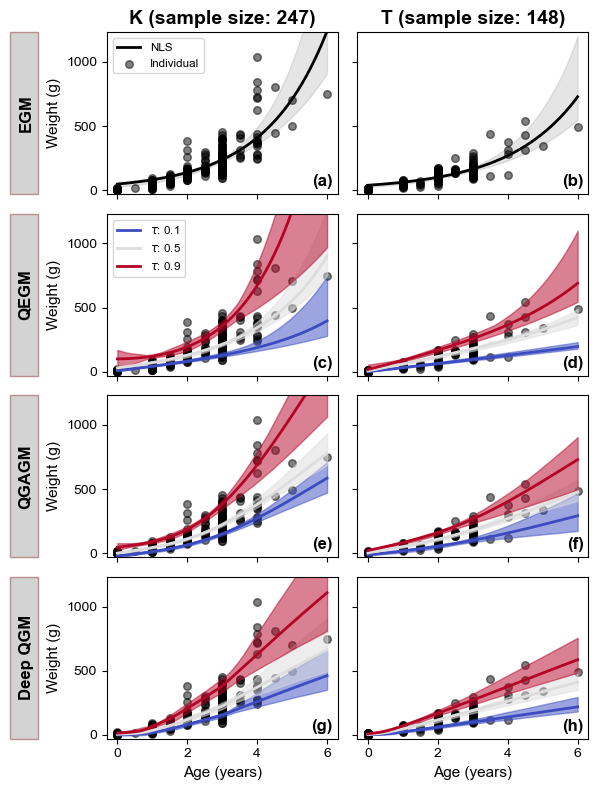

In [2]:
# Growth models
QEGM_results = []
deepQGM_results = []

# CPs: coverage_proportions
QEGM_CPs = []
deepQGM_CPs = []

# Load regression results of QGAGM 
QGAGM_R = pd.read_csv("./Data/cutlassfish_predicts_spline3.csv")

fig, ax = plt.subplots(4, 2, figsize=(6, 8), sharex=True, sharey=True)

for idx_c, site in enumerate(['K', 'T']):
    idx_r = 0
    quantiles = np.linspace(0.1, 0.9, 9)
    hairtail_site = hairtail[hairtail['site'] == site]
    age_site = np.array(hairtail_site.newage)
    size_site = np.array(hairtail_site.total_w)
    age_range = np.linspace(age_site.min(), age_site.max(), 200)

    # Bootstrap EGM with confidence intervals
    a_egm, b_egm, pred_egm, egm_errors = bootstrap_egm(age_site, size_site, n_bootstrap)
    egm_params = [np.mean(a_egm), np.mean(b_egm)]
    a_95CI = [np.percentile(a_egm, 2.5), np.percentile(a_egm, 97.5, axis=0)]
    b_95CI = [np.percentile(b_egm, 2.5), np.percentile(b_egm, 97.5, axis=0)]
    print(f"EGM: Site_{site}: Mean params [a, b]: [{egm_params[0]:.2f}, {egm_params[1]:.2f}]")
    print(f"EGM: Site_{site}: a_95%_CI: [{a_95CI[0]:.2f}, {a_95CI[1]:.2f}]")
    print(f"EGM: Site_{site}: b_95%_CI: [{b_95CI[0]:.2f}, {b_95CI[1]:.2f}]")
    print(f"EGM: Site_{site}: MSE: {np.mean(egm_errors['mse']):.2f}")
    print(f"EGM: Site_{site}: MAE: {np.mean(egm_errors['mae']):.2f}")
    print(f"EGM: Site_{site}: MAPE: {np.mean(egm_errors['mape']):.2f}")
    
    # Plot EGM with confidence intervals
    pred_mean = np.mean(pred_egm, axis=0)
    pred_lower = np.percentile(pred_egm, 2.5, axis=0)
    pred_upper = np.percentile(pred_egm, 97.5, axis=0)
    
    ax[idx_r, idx_c].plot(age_range, pred_mean, 'k-', lw=2, label='NLS')
    ax[idx_r, idx_c].fill_between(age_range, pred_lower, pred_upper, 
                                color='gray', alpha=0.2)
    ax[idx_r, idx_c].scatter(age_site, size_site, color='k', s=30, alpha=0.5, label='Individual')
    if idx_c == 0:
        ax[idx_r, idx_c].set_ylim(-30, 1230)
        ax[idx_r, idx_c].set_yticks([0, 500, 1000])
        ax[idx_r, idx_c].legend(fontsize='small')
        ax[idx_r, idx_c].set_ylabel("Weight (g)", fontsize=11)
        ax[idx_r, 0].set_title(f"K (sample size: {N_K})", fontsize=14, fontweight='bold')
        ax[idx_r, 1].set_title(f"T (sample size: {N_T})", fontsize=14, fontweight='bold')
        ax[idx_r+1, idx_c].set_ylabel("Weight (g)", fontsize=11)
        ax[idx_r+2, idx_c].set_ylabel("Weight (g)", fontsize=11)
        ax[idx_r+3, idx_c].set_ylabel("Weight (g)", fontsize=11)
    
    # Bootstrap QEGM with error calculation
    a_qegm, b_qegm, pred_qegm, qegm_errors, qegm_CPs = bootstrap_qegm(age_site, size_site, egm_params, quantiles, n_bootstrap)
    
    # Plot QEGM with confidence intervals for [0.1, 0.5, 0.9] quantiles
    ax[idx_r+1, idx_c].scatter(age_site, size_site, color='k', s=30, alpha=0.5)
    for idq, q in enumerate(quantiles):
        if q in [0.1, 0.5, 0.9]:
            pred_mean = np.mean(pred_qegm[q], axis=0)
            pred_lower = np.percentile(pred_qegm[q], 2.5, axis=0)
            pred_upper = np.percentile(pred_qegm[q], 97.5, axis=0)
            
            ax[idx_r+1, idx_c].plot(age_range, pred_mean, color=colors[idq], lw=2, 
                                   label=r'$\tau$: '+str(q))
            ax[idx_r+1, idx_c].fill_between(age_range, pred_lower, pred_upper, 
                                           color=colors[idq], alpha=0.5)
    if idx_c == 0:
        ax[idx_r+1, idx_c].legend(fontsize='small')
    
    
    # Bootstrap QGAGM with error calculation    
    ax[idx_r+2, idx_c].scatter(age_site, size_site, color='k', s=30, alpha=0.5)
    site_data = QGAGM_R[QGAGM_R['site'] == site]
    for idq, q in enumerate(quantiles):
        if q in [0.1, 0.5, 0.9]:
            q_data = site_data[site_data['q'] == q]      
            ax[idx_r+2, idx_c].plot(q_data['age'], q_data['mean'], color=colors[idq], lw=2)
            ax[idx_r+2, idx_c].fill_between(q_data['age'], q_data['lower'], q_data['upper'], color=colors[idq], alpha=0.5)

    
    # Bootstrap DeepQGM with error calculation
    pred_deepqgm, deepqgm_errors, deepqgm_CPs = bootstrap_deepqgm(age_site, size_site, quantiles, n_bootstrap)
    
    # Plot DeepQGM with confidence intervals
    ax[idx_r+3, idx_c].scatter(age_site, size_site, color='k', s=30, alpha=0.5)
    for idq, q in enumerate(quantiles):
        if q in [0.1, 0.5, 0.9]:
            pred_mean = np.mean(pred_deepqgm[q], axis=0)
            pred_lower = np.percentile(pred_deepqgm[q], 2.5, axis=0)
            pred_upper = np.percentile(pred_deepqgm[q], 97.5, axis=0)
            
            ax[idx_r+3, idx_c].plot(age_range, pred_mean, color=colors[idq], lw=2)
            ax[idx_r+3, idx_c].fill_between(age_range, pred_lower[:,0], pred_upper[:,0], 
                                          color=colors[idq], alpha=0.5)
            ax[idx_r+3, idx_c].set_xlabel("Age (years)", fontsize=11)
    
    # Store bootstrap-calculated errors
    for idq, q in enumerate(quantiles):
        QEGM_results.append({
            'sites': site, 'q': q, 
            'a': np.mean(a_qegm[q]),
            'a_ci_lower': np.percentile(a_qegm[q], 2.5),
            'a_ci_upper': np.percentile(a_qegm[q], 97.5),
            'b': np.mean(b_qegm[q]),
            'b_ci_lower': np.percentile(b_qegm[q], 2.5),
            'b_ci_upper': np.percentile(b_qegm[q], 97.5),
            'mse': np.mean(qegm_errors[q]['mse']),
            'mae': np.mean(qegm_errors[q]['mae']),
            'mape': np.mean(qegm_errors[q]['mape'])
        })
        
        deepQGM_results.append({
            'sites': site, 'q': q,
            'mse': np.mean(deepqgm_errors[q]['mse']),
            'mae': np.mean(deepqgm_errors[q]['mae']),
            'mape': np.mean(deepqgm_errors[q]['mape'])
        })

    # Store bootstrap-calculated CPs
    QEGM_CPs.append({'sites': site, 'CPs': np.mean(qegm_CPs)})
    deepQGM_CPs.append({'sites': site, 'CPs': np.mean(deepqgm_CPs)})

# Annotations and formatting
annotations = ['EGM', 'QEGM', 'QGAGM', 'Deep QGM']
for i, ax_ in enumerate(ax[:, 0]):
    ax_.annotate(annotations[i], xy=(-0.35, 0.5), xycoords='axes fraction', fontsize=12, fontweight='bold',
                 rotation=90, ha='center', va='center')
    rectangle = Rectangle((-0.42, 0), 0.12, 1, transform=ax_.transAxes, facecolor="lightgray", edgecolor="rosybrown", clip_on=False)
    ax_.add_patch(rectangle)

# Add panel labels
Alphbeta = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax_ in enumerate(ax.flatten()):
    ax_.text(float(0.98), float(0.05), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=12, fontweight='bold')

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_4.pdf")
plt.savefig("./Figs/Figure_4.png", format="png", dpi=600, bbox_inches="tight")

## Model performance

- Panel a and b: quantile-specific parameter estimates with 95% CIs for QEGM
- Panel c: coverage probability (CPs) across QEGM, QGAGM, and deep QGM
- Panel d: quantile-specific mean prediction errors across QEGM, QGAGM, and deep QGM

[Mean Absolute Percentage Error (MAPE)](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error):

If $\hat{y}_i$ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value, then the mean absolute percentage error (MAPE) estimated over $n$ is defined as:

$$\text{MAPE}(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} \frac{|y_i - \hat{y}_i|}{\max(\epsilon, |y_i|)}$$

where:
- $n$ = number of samples
- $\epsilon$ is a small positive constant to avoid division by zero

In [3]:
rows = []
for item in QEGM_CPs:
    rows.append({'methods': 'QEGM', 'sites': item['sites'], 'CPs': item['CPs']})
for item in deepQGM_CPs:
    rows.append({'methods': 'deep QGM', 'sites': item['sites'], 'CPs': item['CPs']})
QEGM_deepQGM_CPs_df = pd.DataFrame(rows)
QEGM_deepQGM_CPs_df = QEGM_deepQGM_CPs_df[['methods', 'sites', 'CPs']]

CPs_R = pd.read_csv("./Data/cutlassfish_CPs_spline3.csv")
coverage_means = CPs_R.groupby('site')['coverage'].mean().reset_index()
QGAGM_CPs_df = pd.DataFrame({'methods': 'QGAGM', 'sites': coverage_means['site'], 'CPs': coverage_means['coverage']})

CPs_df = pd.concat([QEGM_deepQGM_CPs_df, QGAGM_CPs_df], ignore_index=True).sort_values(['methods']).reset_index(drop=True)
CPs_df

,methods,sites,CPs
0,QEGM,K,0.704619
1,QEGM,T,0.786926
2,QGAGM,K,0.867700
3,QGAGM,T,0.889429
4,deep QGM,K,0.796318
5,deep QGM,T,0.793720


In [4]:
Errors_R = pd.read_csv("./Data/cutlassfish_errors_spline3.csv")

QGAGM_df = (Errors_R.groupby(['site', 'q']).agg({'mse': ['mean'], 'mae': ['mean'], 'mape': ['mean']})
          .round(4).reset_index())

QGAGM_df.columns = ['sites', 'q', 'mse', 'mae', 'mape']
QGAGM_df

,sites,q,mse,mae,mape
0,K,0.1,16496.5733,82.0037,0.8179
1,K,0.2,12814.0318,65.8666,0.4930
2,K,0.3,10835.0915,57.8653,0.3942
3,K,0.4,9733.8149,54.4409,0.3853
4,K,0.5,8829.4670,53.5335,0.3846
5,K,0.6,8203.4688,55.6390,0.4369
6,K,0.7,8642.1841,62.8142,0.5830
7,K,0.8,12721.2674,81.0487,0.9126
8,K,0.9,26400.4822,121.9199,1.6794
9,T,0.1,6011.6164,52.5044,3.9698


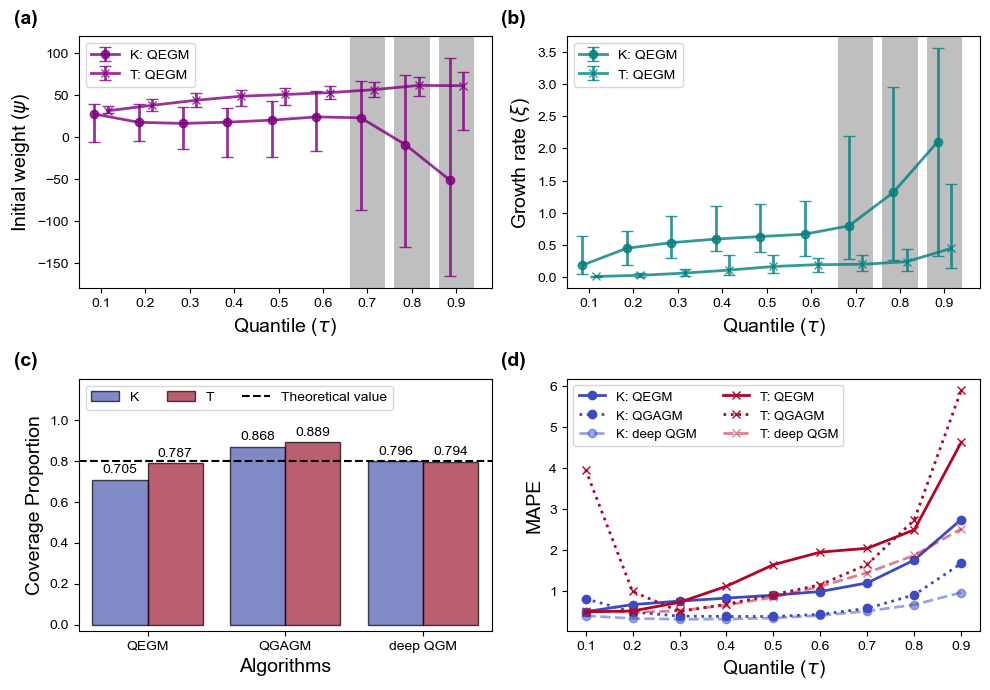

In [5]:
QEGM_df = pd.DataFrame(QEGM_results)
deepQGM_df = pd.DataFrame(deepQGM_results)

colors2 = {'K': colors[0], 'T': colors[8]}
colors1 = {'a': 'purple', 'b': 'teal'}
markers = {'K': 'o', 'T': 'x'}

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

# Define offset for dodging errorbars
dodge_width = 0.015

# Panel a: Parameter a (initial weight) of QEGM with error bars
for site in QEGM_df['sites'].unique():
    site_data = QEGM_df[QEGM_df['sites'] == site]
    offset = -dodge_width if site == 'K' else dodge_width  # add offset
    a_error_lower = site_data['a'] - site_data['a_ci_lower']
    a_error_upper = site_data['a_ci_upper'] - site_data['a']
    ax[0,0].errorbar(site_data['q'] + offset, site_data['a'], yerr=[a_error_lower, a_error_upper],
                   marker=markers[site], markersize=6, lw=2, linestyle='-',
                   color=colors1['a'], alpha=0.8, label=f'{site}: QEGM',
                   capsize=4, elinewidth=2)

ax[0,0].axvspan(0.86, 0.94, alpha=0.5, facecolor='grey')  # Grey vertical bands at 0.9 quantile
ax[0,0].axvspan(0.76, 0.84, alpha=0.5, facecolor='grey')
ax[0,0].axvspan(0.66, 0.74, alpha=0.5, facecolor='grey')
ax[0,0].set_xlim(0.05, 0.98)
ax[0,0].set_xticks(np.linspace(0.1, 0.9, 9))
ax[0,0].set_xlabel(r'Quantile ($\tau$)', fontsize=14)
ax[0,0].set_ylim(-180, 120)
ax[0,0].set_ylabel(r'Initial weight ($\psi$)', fontsize=14)
ax[0,0].legend(fontsize=10)


# Panel b: Coverage Proportion
for site in QEGM_df['sites'].unique():
    site_data = QEGM_df[QEGM_df['sites'] == site]
    offset = -dodge_width if site == 'K' else dodge_width  # add offset
    b_error_lower = site_data['b'] - site_data['b_ci_lower']
    b_error_upper = site_data['b_ci_upper'] - site_data['b']
    ax[0,1].errorbar(site_data['q'] + offset, site_data['b'], yerr=[b_error_lower, b_error_upper],
                   marker=markers[site], markersize=6, lw=2, linestyle='-',
                   color=colors1['b'], alpha=0.8, label=f'{site}: QEGM',
                   capsize=4, elinewidth=2)

ax[0,1].axvspan(0.86, 0.94, alpha=0.5, facecolor='grey')  # Grey vertical bands at 0.9 quantile
ax[0,1].axvspan(0.76, 0.84, alpha=0.5, facecolor='grey')
ax[0,1].axvspan(0.66, 0.74, alpha=0.5, facecolor='grey')
ax[0,1].set_xlim(0.05, 0.98)
ax[0,1].set_xticks(np.linspace(0.1, 0.9, 9))
ax[0,1].set_xlabel(r'Quantile ($\tau$)', fontsize=14)
ax[0,1].set_ylabel(r'Growth rate ($\xi$)', fontsize=14)
ax[0,1].legend(fontsize=10)


# Panel c: Mean absolute percentage error (MAPE) curves with bootstrap means
bar_width = 0.35
x = np.arange(len(CPs_df))  # x positions for algorithms

# Plot bar chart for each algorithms
sns.barplot(data=CPs_df, x='methods', y='CPs', hue='sites', ax=ax[1,0],
            palette=colors2, alpha=0.7, edgecolor='black', linewidth=1)

# Add theoretical value line (0.8)
ax[1,0].axhline(y=0.8, color='k', linestyle='--', label='Theoretical value')

# Set chart titles and labels
ax[1,0].set_xlabel('Algorithms', fontsize=14)
ax[1,0].set_ylabel('Coverage Proportion', fontsize=14)
ax[1,0].set_ylim(-0.03, 1.2)
ax[1,0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[1,0].legend(ncol=3, loc='upper left', fontsize=10)

# # Add value labels on top of each bar
for container in ax[1,0].containers:
    ax[1,0].bar_label(container, fmt='%.3f', padding=3, fontsize=10)

# Panel d: Mean absolute percentage error (MAPE) curves with bootstrap means
for site in ['K', 'T']:
    qegm_data = QEGM_df[QEGM_df['sites'] == site]
    qgagm_data = QGAGM_df[QGAGM_df['sites'] == site]
    deepqgm_data = deepQGM_df[deepQGM_df['sites'] == site]
    
    ax[1,1].plot(qegm_data['q'], qegm_data['mape'], marker=markers[site], markersize=6, lw=2,
               linestyle='-', color=colors2[site], label=f'{site}: QEGM')
    ax[1,1].plot(qgagm_data['q'], qgagm_data['mape'], marker=markers[site], markersize=6, lw=2,
               linestyle=':', color=colors2[site], label=f'{site}: QGAGM')    
    ax[1,1].plot(deepqgm_data['q'], deepqgm_data['mape'], marker=markers[site], markersize=6, lw=2,
               linestyle='--', color=colors2[site], label=f'{site}: deep QGM', alpha=0.5)

ax[1,1].set_xlabel(r'Quantile ($\tau$)', fontsize=14)
ax[1,1].set_ylabel('MAPE', fontsize=14)
ax[1,1].legend(fontsize=9.5, ncol=2)


# Add panel labels
Alphbeta = ['a', 'b', 'c', 'd']
for i, ax_ in enumerate(ax.flatten()):
    ax_.text(float(-0.1), float(1.05), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=14, fontweight='bold')

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_5.pdf")
plt.savefig("./Figs/Figure_5.png", format="png", dpi=600, bbox_inches="tight")

[Mean Squared Error (MSE)](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error):

If $\hat{y}_i$ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value, then the mean squared error (MSE) estimated over $n$ is defined as:

$$\text{MSE}(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} {(y_i - \hat{y}_i)^2}$$

where: $n$ = number of samples</br></br></br>

[Mean Absolute Error (MAE)](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error):

If $\hat{y}_i$ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value, then the mean absolute error (MAE) estimated over $n$ is defined as:

$$\text{MAE}(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} {|y_i - \hat{y}_i|}$$

where: $n$ = number of samples

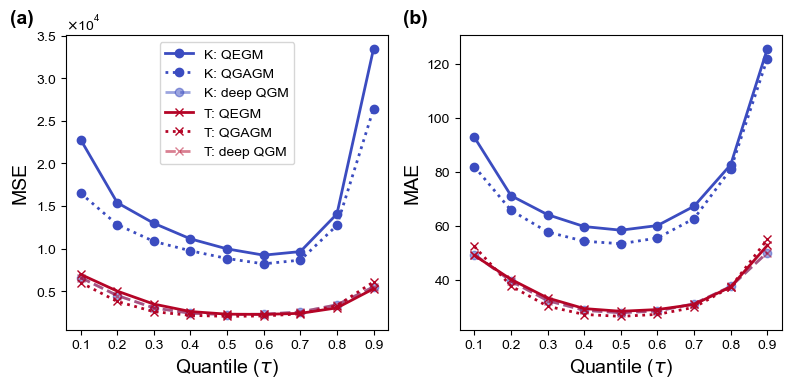

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

for site in ['K', 'T']:
    qegm_data = QEGM_df[QEGM_df['sites'] == site]
    qgagm_data = QGAGM_df[QGAGM_df['sites'] == site]
    deepqegm_data = deepQGM_df[deepQGM_df['sites'] == site]

    # MSE Subplot
    ax[0].plot(qegm_data['q'], qegm_data['mse'], marker=markers[site], markersize=6, lw=2,
               linestyle='-', color=colors2[site], label=f'{site}: QEGM')
    ax[0].plot(qgagm_data['q'], qgagm_data['mse'], marker=markers[site], markersize=6, lw=2,
               linestyle=':', color=colors2[site], label=f'{site}: QGAGM')    
    ax[0].plot(deepqgm_data['q'], deepqgm_data['mse'], marker=markers[site], markersize=6, lw=2,
               linestyle='--', color=colors2[site], label=f'{site}: deep QGM', alpha=0.5)

    # MAE Subplot
    ax[1].plot(qegm_data['q'], qegm_data['mae'], marker=markers[site], markersize=6, lw=2,
               linestyle='-', color=colors2[site], label=f'{site}: QEGM')
    ax[1].plot(qgagm_data['q'], qgagm_data['mae'], marker=markers[site], markersize=6, lw=2,
               linestyle=':', color=colors2[site], label=f'{site}: QGAGM')    
    ax[1].plot(deepqgm_data['q'], deepqgm_data['mae'], marker=markers[site], markersize=6, lw=2,
               linestyle='--', color=colors2[site], label=f'{site}: deep QGM', alpha=0.5)

# Formatting for MSE subplot (Panel a)
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))  # Scientific notation for y-axis
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].set_xticks(np.linspace(0.1, 0.9, 9))
ax[0].set_xlabel(r'Quantile ($\tau$)', fontsize=14)
ax[0].set_ylabel('MSE', fontsize=14)
ax[0].legend()

# Formatting for MAE subplot (Panel b)
ax[1].set_xlabel(r'Quantile ($\tau$)', fontsize=14)
ax[1].set_ylabel('MAE', fontsize=14)

# Add panel labels
Alphbeta = ['a', 'b']
for i, ax_ in enumerate(ax.flatten()):
    ax_.text(float(-0.1), float(1.04), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=14, fontweight='bold')

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_S3.pdf")
plt.savefig("./Figs/Figure_S3.png", format="png", dpi=600, bbox_inches="tight")

In [7]:
QEGM_df

,sites,q,a,a_ci_lower,a_ci_upper,b,b_ci_lower,b_ci_upper,mse,mae,mape
0,K,0.1,27.431117,-5.604818,39.235452,0.188192,0.052677,0.633724,22793.118300,92.833008,0.501312
1,K,0.2,17.539885,-4.340184,39.439688,0.450957,0.189636,0.714345,15381.148533,71.282531,0.675507
2,K,0.3,16.225735,-14.574082,35.530196,0.537517,0.305525,0.949038,12962.760332,64.252427,0.760615
3,K,0.4,17.691849,-23.467960,34.501857,0.593439,0.410879,1.112813,11134.536015,59.864398,0.833254
4,K,0.5,20.125773,-23.187573,42.439157,0.632987,0.400007,1.140630,9959.013447,58.526871,0.904193
5,K,0.6,23.963070,-17.072987,55.046277,0.668693,0.335732,1.190835,9223.548561,60.245540,0.994004
6,K,0.7,22.898635,-87.312806,66.427638,0.798653,0.283312,2.196555,9641.807725,67.383933,1.204172
7,K,0.8,-8.915446,-131.363237,73.765549,1.318486,0.263384,2.947153,14063.729735,82.726256,1.763492
8,K,0.9,-51.092043,-165.099319,94.266619,2.106528,0.326596,3.564440,33460.365664,125.562841,2.752134
9,T,0.1,31.224197,28.369470,36.723031,0.012782,0.008093,0.025585,6965.924075,49.205566,0.498300


In [8]:
QGAGM_df

,sites,q,mse,mae,mape
0,K,0.1,16496.5733,82.0037,0.8179
1,K,0.2,12814.0318,65.8666,0.4930
2,K,0.3,10835.0915,57.8653,0.3942
3,K,0.4,9733.8149,54.4409,0.3853
4,K,0.5,8829.4670,53.5335,0.3846
5,K,0.6,8203.4688,55.6390,0.4369
6,K,0.7,8642.1841,62.8142,0.5830
7,K,0.8,12721.2674,81.0487,0.9126
8,K,0.9,26400.4822,121.9199,1.6794
9,T,0.1,6011.6164,52.5044,3.9698


In [9]:
deepQGM_df

,sites,q,mse,mae,mape
0,K,0.1,16720.299988,77.470570,0.402211
1,K,0.2,13604.904202,65.898501,0.336625
2,K,0.3,11571.760569,59.077059,0.316878
3,K,0.4,10249.047356,55.628160,0.320787
4,K,0.5,9182.732641,54.341909,0.348108
5,K,0.6,8525.723073,56.201997,0.409086
6,K,0.7,8885.649582,62.567190,0.516762
7,K,0.8,11431.500909,77.240442,0.670996
8,K,0.9,22250.249570,114.459923,0.969709
9,T,0.1,6588.725383,49.534180,0.528269
